In [25]:
# Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.stats import norm, kurtosis, skew, chi2
from numpy.linalg import cholesky

In [26]:
# Get market data
tickers = ['TSLA', 'AAPL', 'FB', 'NVDA', 'MSFT', 'AMZN']
start = (dt.datetime.now() - relativedelta(years=1)).strftime('%Y-%m-%d')
end = dt.datetime.now()
df = yf.download(tickers,start)['Adj Close']

[*********************100%***********************]  6 of 6 completed


In [27]:
# Define weights & estimate returns
weights = np.random.rand(len(tickers)) # random weights
weights /= np.sum(weights) # force total portfolio equal to one
port_ret = np.log(df/df.shift(1)).dropna() # logarithmic returns

#Get financials
ret = port_ret.mean().values
mean = np.dot(weights.T,ret)
cov = port_ret.cov()
std = np.sqrt(
        np.dot(weights.T,np.dot(cov,weights))
)
last_price = np.dot(df.iloc[-1].values,weights.T)

In [28]:
# Parametric VaR
confidence_level = norm.ppf(0.99)
time_delta = 1
VaR = mean - (confidence_level * std * np.sqrt(time_delta))
VaR_perc = VaR * 100
print('Value at Risk of Portfolio is {0:.2f}%'.format(VaR_perc))


Value at Risk of Portfolio is -3.49%


In [29]:
'''
# Jarque-Bera test
x = np.dot(port_ret.values,weights)
#x = df.pct_change().dropna().values
sample = len(x)
skewness = skew(x)
exced_kurtosis = kurtosis(x)
jb_stat = (sample/6) * (skewness**2 + 1/4*exced_kurtosis**2)
p_value =1 - chi2.cdf(jb_stat, df=sample)
ret_is_normal = (p_value > 0.05)
ret_is_normal
'''

'\n# Jarque-Bera test\nx = np.dot(port_ret.values,weights)\n#x = df.pct_change().dropna().values\nsample = len(x)\nskewness = skew(x)\nexced_kurtosis = kurtosis(x)\njb_stat = (sample/6) * (skewness**2 + 1/4*exced_kurtosis**2)\np_value =1 - chi2.cdf(jb_stat, df=sample)\nret_is_normal = (p_value > 0.05)\nret_is_normal\n'

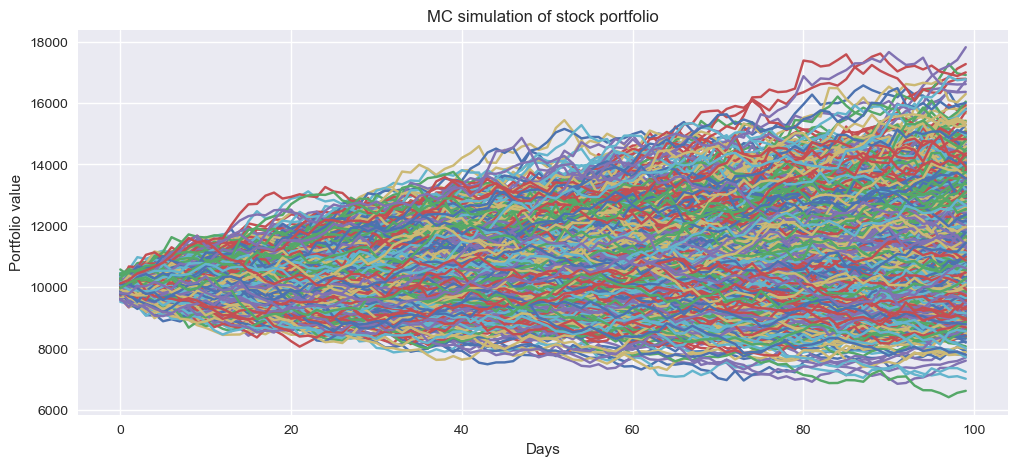

In [41]:
# Monte-Carlo simulation
simulations = 1000
T = 100
mean_mtx = np.full(shape=(T, len(weights)), fill_value=ret).T
portf_simulations = np.full(shape=(T, simulations),fill_value=0.0)
initial_portf = 10000

for i in range(0, simulations):
     Z = np.random.normal(size=(T, len(weights)))
     L = cholesky(cov)
     daily_ret = mean_mtx + np.inner(L,Z)
     portf_simulations[:,i] = np.cumprod(np.inner(weights,daily_ret.T)+1)*initial_portf

plt.figure(figsize=(12,5))
plt.style.use('seaborn')
plt.plot(portf_simulations)
plt.ylabel('Portfolio value')
plt.xlabel('Days')
plt.title('MC simulation of stock portfolio')
plt.show()

